In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


5-year Sales Data:


,Sales
2020-01-31,102.483571
2020-02-29,111.308678
2020-03-31,124.558951
2020-04-30,133.615149
2020-05-31,124.149741


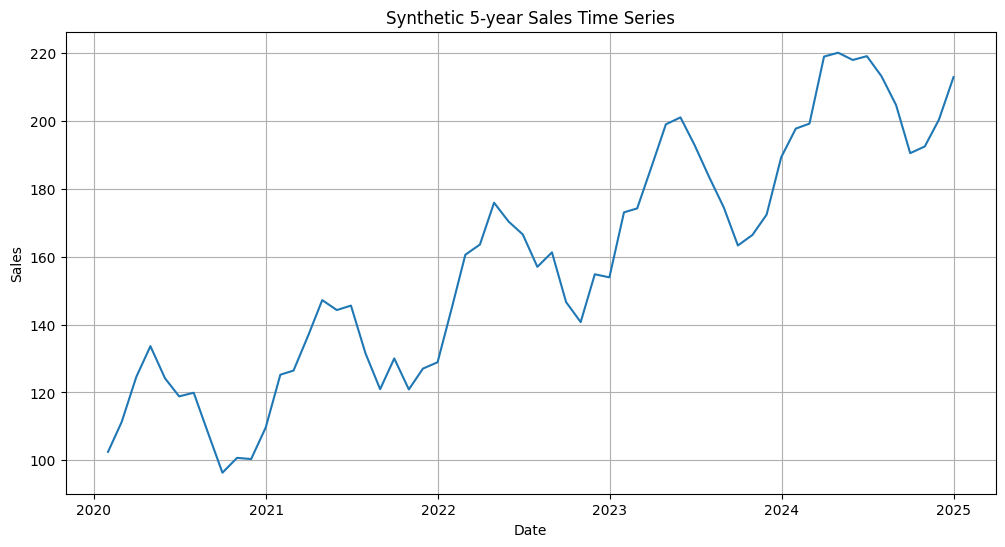

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Generate 5-year synthetic sales data ---
np.random.seed(42) # for reproducibility
n_5years = 60 # 5 years of monthly data
beta0 = 100 # intercept
beta1 = 2 # trend coefficient
A = 20 # seasonal amplitude
P = 12 # seasonal period (12 months)
sigma = 5 # noise level

# Generate time index
t_5years = np.arange(n_5years)

# Generate seasonal component
seasonal_component_5years = A * np.sin(2 * np.pi * t_5years / P)

# Generate trend component
trend_component_5years = beta0 + beta1 * t_5years

# Generate noise
noise_5years = np.random.normal(0, sigma, n_5years)

# Generate sales data
sales_5years = trend_component_5years + seasonal_component_5years + noise_5years

# Create a pandas DataFrame for 5 years
dates_5years = pd.date_range(start='2020-01-31', periods=n_5years, freq='ME')
df_sales_5years = pd.DataFrame({'Sales': sales_5years}, index=dates_5years)

# Display the first few rows of the 5-year DataFrame
print("5-year Sales Data:")
display(df_sales_5years.head())

# Plot the 5-year time series
plt.figure(figsize=(12, 6))
plt.plot(df_sales_5years.index, df_sales_5years['Sales'])
plt.title("Synthetic 5-year Sales Time Series")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

In [4]:
#define metrics(MAE,MSE,RMSE,MAPE,R^2)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mape(y_true, y_pred):
    return np

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))



In [5]:
# These variables are not needed for the naive forecast
# series = baseline + trend(time,slope) + seasonality(time, period=365,amplitude =amplitude) + noise(time, noise_level, seed = 42)
# series = series + noise(time, noise_level, seed = 42)

In [6]:
# Split train/valid
# Using the generated 5-year sales data
time = df_sales_5years.index
series = df_sales_5years['Sales'].values

split_time = int(len(series) * 0.8) # Using 80% for training, 20% for validation
time_train, time_valid = time[:split_time], time[split_time:]
x_train, x_valid = series[:split_time], series[split_time:]

Naive Forecast Metrics:
MAE: 6.9625
MSE: 84.6210
RMSE: 9.1990
R^2: 0.2450


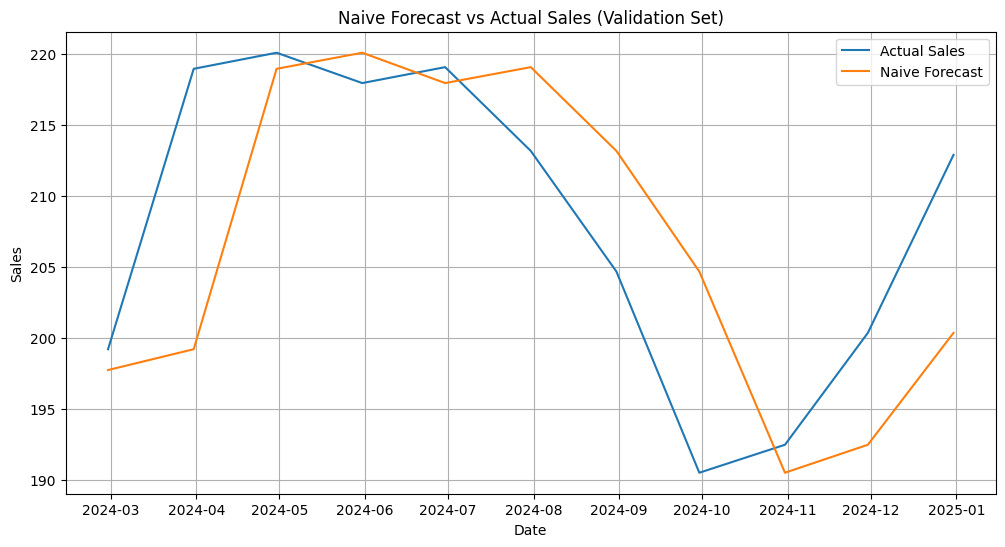

In [7]:
# Implement Naive Forecast (yt+1 = yt)
naive_forecast = x_valid[:-1] # Forecast is the previous value

# To align the lengths for evaluation metrics, we need to remove the first actual value
# since the naive forecast starts from the second value of the validation set.
y_true = x_valid[1:]
y_pred = naive_forecast

# Calculate metrics for the naive forecast
mae_naive = mae(y_true, y_pred)
mse_naive = mse(y_true, y_pred)
rmse_naive = rmse(y_true, y_pred)
r2_naive = r2(y_true, y_pred)

print(f"Naive Forecast Metrics:")
print(f"MAE: {mae_naive:.4f}")
print(f"MSE: {mse_naive:.4f}")
print(f"RMSE: {rmse_naive:.4f}")
print(f"R^2: {r2_naive:.4f}")

# Plot Naive Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(time_valid[1:], y_true, label='Actual Sales')
plt.plot(time_valid[1:], y_pred, label='Naive Forecast')
plt.title("Naive Forecast vs Actual Sales (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

## Create directories



In [8]:
import os

base_dir = '/content/drive/MyDrive/'
time_series_dir = os.path.join(base_dir, 'Time series')
naive_forecast_dir = os.path.join(time_series_dir, 'Naive Forecast')

os.makedirs(naive_forecast_dir, exist_ok=True)
print(f"Created directory: {naive_forecast_dir}")

Created directory: /content/drive/MyDrive/Time series/Naive Forecast


## Move saved files



In [9]:
import shutil

source_results = '/content/naive_forecast_results.csv'
source_metrics = '/content/naive_forecast_metrics.json'
destination_dir = '/content/drive/MyDrive/Time series/Naive Forecast'

shutil.move(source_results, destination_dir)
shutil.move(source_metrics, destination_dir)

print(f"Moved {source_results} to {destination_dir}")
print(f"Moved {source_metrics} to {destination_dir}")

Error: Destination path '/content/drive/MyDrive/Time series/Naive Forecast/naive_forecast_results.csv' already exists

## Save Naive Forecast Plots



In [ ]:
# Save the Naive Forecast vs Actual plot
naive_plot_filename = 'naive_forecast_vs_actual_plot.png'
plt.figure(figsize=(12, 6))
plt.plot(time_valid[1:], y_true, label='Actual Sales')
plt.plot(time_valid[1:], y_pred, label='Naive Forecast')
plt.title("Naive Forecast vs Actual Sales (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.savefig(naive_plot_filename)
plt.close() # Close the plot to avoid displaying it again
print(f"Saved Naive Forecast vs Actual plot to {naive_plot_filename}")

# Define the destination directory on Google Drive
naive_forecast_dir = '/content/drive/MyDrive/Time series/Naive Forecast'

# Move the saved plot file to the Google Drive directory
shutil.move(naive_plot_filename, naive_forecast_dir)

print(f"Moved {naive_plot_filename} to {naive_forecast_dir}")

## Prepare data for linear regression


In [10]:
# Create a new DataFrame for linear regression
df_linear_regression = pd.DataFrame()

# Shift the 'Sales' column to create the feature (yt)
df_linear_regression['yt'] = df_sales_5years['Sales'].shift(1)

# Use the original 'Sales' as the target (yt+1)
df_linear_regression['yt+1'] = df_sales_5years['Sales']

# Drop the first row which will have a missing value in 'yt' due to the shift
df_linear_regression = df_linear_regression.dropna()

# Display the first few rows of the new DataFrame
print("Linear Regression Data:")
display(df_linear_regression.head())

Linear Regression Data:


,yt,yt+1
2020-02-29,102.483571,111.308678
2020-03-31,111.308678,124.558951
2020-04-30,124.558951,133.615149
2020-05-31,133.615149,124.149741
2020-06-30,124.149741,118.829315


## Split data


In [11]:
# Note: The split_time variable is based on the original df_sales_5years length (60),
# Since the split was done at index 48 for the 60-length series,the corresponding index for the 59-length series will be 47 (split_time - 1).
split_index_lr = split_time - 1

# Split features (X) and target (y) for training and validation
X = df_linear_regression[['yt']]
y = df_linear_regression['yt+1']

X_train, X_valid = X[:split_index_lr], X[split_index_lr:]
y_train, y_valid = y[:split_index_lr], y[split_index_lr:]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of X_train: (47, 1)
Shape of y_train: (47,)
Shape of X_valid: (12, 1)
Shape of y_valid: (12,)


## Train linear regression model


In [12]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

print("Linear Regression model trained successfully.")
print(f"Intercept: {linear_regression_model.intercept_:.4f}")
print(f"Coefficient (for yt): {linear_regression_model.coef_[0]:.4f}")

Linear Regression model trained successfully.
Intercept: 10.5408
Coefficient (for yt): 0.9401


## Make predictions


In [13]:
# Make predictions on the validation set
linear_regression_predictions = linear_regression_model.predict(X_valid)

# Display the first few predictions
print("Linear Regression Predictions on Validation Set:")
print(linear_regression_predictions[:5])

Linear Regression Predictions on Validation Set:
[188.48124688 196.40831249 197.7871107  216.35912303 217.42483587]


## Evaluate linear regression model


In [14]:
# Calculate metrics for the linear regression forecast
mae_lr = mae(y_valid, linear_regression_predictions)
mse_lr = mse(y_valid, linear_regression_predictions)
rmse_lr = rmse(y_valid, linear_regression_predictions)
r2_lr = r2(y_valid, linear_regression_predictions)

print(f"Linear Regression Forecast Metrics:")
print(f"MAE: {mae_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R^2: {r2_lr:.4f}")

Linear Regression Forecast Metrics:
MAE: 7.3996
MSE: 88.0119
RMSE: 9.3815
R^2: 0.2070


## Compare with naive forecast


In [15]:
print("--- Comparison of Forecast Metrics ---")
print("\nNaive Forecast Metrics:")
print(f"MAE: {mae_naive:.4f}")
print(f"MSE: {mse_naive:.4f}")
print(f"RMSE: {rmse_naive:.4f}")
print(f"R^2: {r2_naive:.4f}")

print("\nLinear Regression Forecast Metrics:")
print(f"MAE: {mae_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R^2: {r2_lr:.4f}")

print("\n--- Comparison Summary ---")
if mae_lr < mae_naive:
    print("Linear Regression has a slightly lower MAE than Naive Forecast.")
elif mae_lr > mae_naive:
    print("Naive Forecast has a slightly lower MAE than Linear Regression.")
else:
    print("Linear Regression and Naive Forecast have similar MAE.")

if mse_lr < mse_naive:
    print("Linear Regression has a slightly lower MSE than Naive Forecast.")
elif mse_lr > mse_naive:
    print("Naive Forecast has a slightly lower MSE than Linear Regression.")
else:
    print("Linear Regression and Naive Forecast have similar MSE.")

if rmse_lr < rmse_naive:
    print("Linear Regression has a slightly lower RMSE than Naive Forecast.")
elif rmse_lr > rmse_naive:
    print("Naive Forecast has a slightly lower RMSE than Linear Regression.")
else:
    print("Linear Regression and Naive Forecast have similar RMSE.")

if r2_lr > r2_naive:
    print("Linear Regression has a slightly higher R^2 than Naive Forecast.")
elif r2_lr < r2_naive:
    print("Naive Forecast has a slightly higher R^2 than Linear Regression.")
else:
    print("Linear Regression and Naive Forecast have similar R^2.")

--- Comparison of Forecast Metrics ---

Naive Forecast Metrics:
MAE: 6.9625
MSE: 84.6210
RMSE: 9.1990
R^2: 0.2450

Linear Regression Forecast Metrics:
MAE: 7.3996
MSE: 88.0119
RMSE: 9.3815
R^2: 0.2070

--- Comparison Summary ---
Naive Forecast has a slightly lower MAE than Linear Regression.
Naive Forecast has a slightly lower MSE than Linear Regression.
Naive Forecast has a slightly lower RMSE than Linear Regression.
Naive Forecast has a slightly higher R^2 than Linear Regression.


## Visualize linear regression results



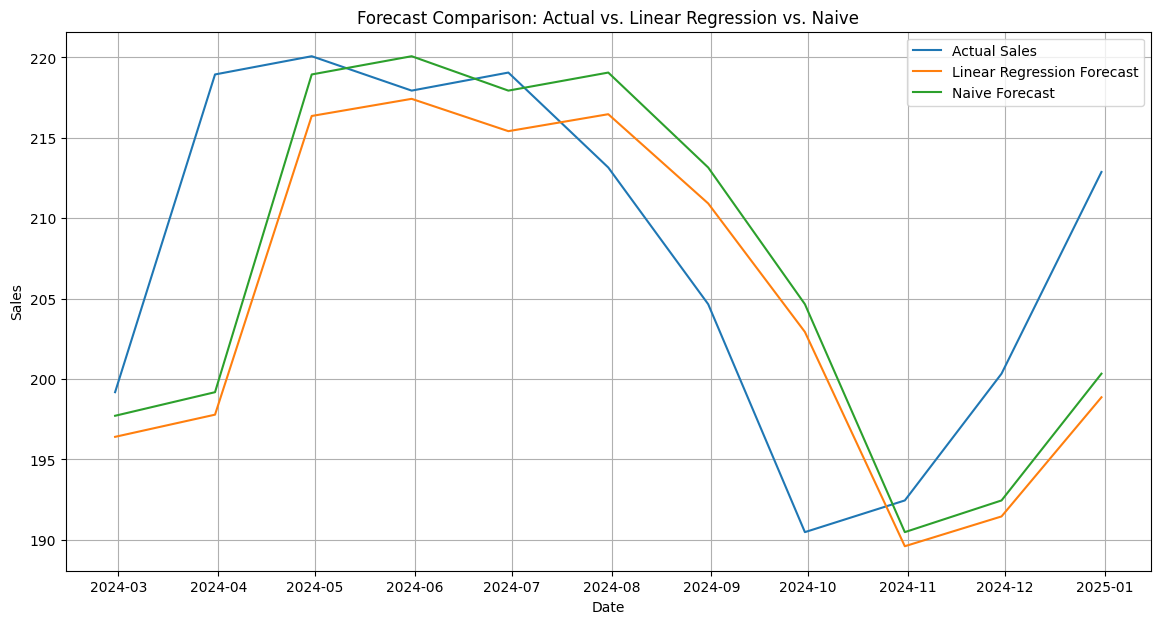

In [16]:
# Plot Actual vs. Linear Regression Forecast vs. Naive Forecast on the validation set
plt.figure(figsize=(14, 7)) # Step 1
# Actual values for comparison start from the second element of the validation set
plt.plot(time_valid[1:], y_valid[1:], label='Actual Sales') # Step 2
plt.plot(time_valid[1:], linear_regression_predictions[1:], label='Linear Regression Forecast') # Step 3
plt.plot(time_valid[1:], y_pred, label='Naive Forecast') # Step 4
plt.title("Forecast Comparison: Actual vs. Linear Regression vs. Naive") # Step 5
plt.xlabel("Date") # Step 6
plt.ylabel("Sales") # Step 7
plt.legend() # Step 8
plt.grid(True) # Step 9
plt.show() # Step 10

## Analyze residuals



Linear Regression Residuals Statistics:


,yt+1
count,12.000000
mean,3.728639
std,8.991459
min,-12.447358
25%,-0.445338
50%,3.245370
75%,8.966312
max,21.153817


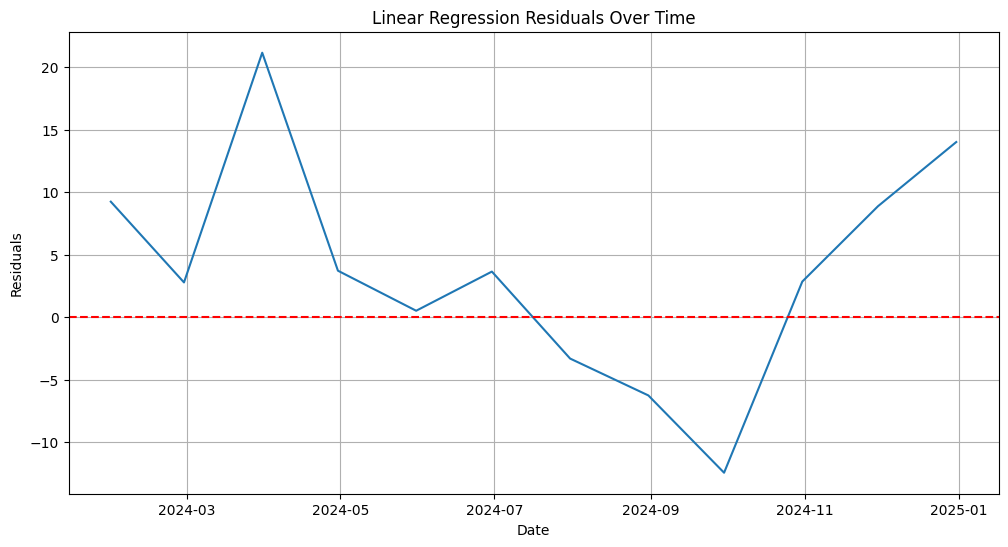

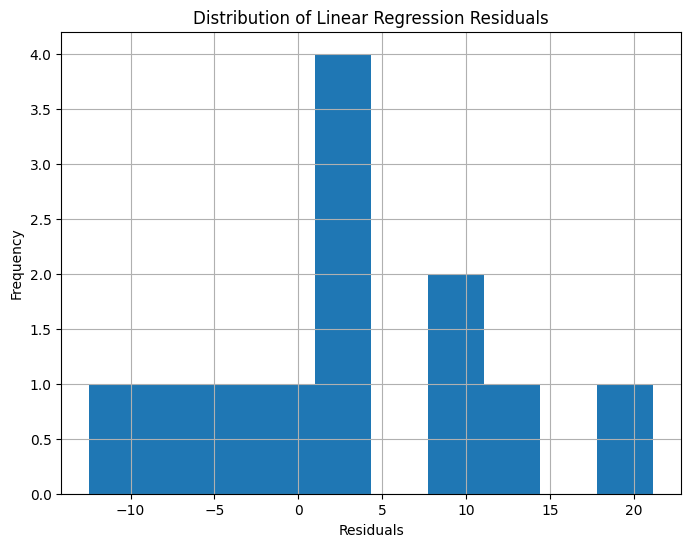

In [17]:
# Calculate residuals
linear_regression_residuals = y_valid - linear_regression_predictions

# Print basic statistics of the residuals
print("Linear Regression Residuals Statistics:")
display(linear_regression_residuals.describe())

# Create a line plot of the residuals over time
plt.figure(figsize=(12, 6))
plt.plot(time_valid, linear_regression_residuals)
plt.title("Linear Regression Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at y=0 for reference
plt.grid(True)
plt.show()

# Create a histogram of the residuals
plt.figure(figsize=(8, 6))
plt.hist(linear_regression_residuals, bins=10) # Adjust bins as needed
plt.title("Distribution of Linear Regression Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
import json
import os
import shutil

# Create a DataFrame to save predictions, actual values, and residuals
linear_regression_results = pd.DataFrame({
    'Actual': y_valid,
    'Linear_Regression_Forecast': linear_regression_predictions,
    'Residuals': linear_regression_residuals
})

# Save the results DataFrame to a CSV file
results_filename = 'linear_regression_results.csv'
linear_regression_results.to_csv(results_filename)
print(f"Saved linear regression results to {results_filename}")

# Create a dictionary for evaluation metrics
linear_regression_metrics = {
    'MAE': mae_lr,
    'MSE': mse_lr,
    'RMSE': rmse_lr,
    'R^2': r2_lr
}

# Save the evaluation metrics to a JSON file
metrics_filename = 'linear_regression_metrics.json'
with open(metrics_filename, 'w') as f:
    json.dump(linear_regression_metrics, f, indent=4)
print(f"Saved linear regression metrics to {metrics_filename}")

# Define the destination directory on Google Drive
destination_dir_lr = '/content/drive/MyDrive/Time series/Linear Regression'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir_lr, exist_ok=True)
print(f"Created directory: {destination_dir_lr}")

# Move the saved files to the Google Drive directory
shutil.move(results_filename, destination_dir_lr)
shutil.move(metrics_filename, destination_dir_lr)

print(f"Moved {results_filename} to {destination_dir_lr}")
print(f"Moved {metrics_filename} to {destination_dir_lr}")

In [ ]:
# Verify the files are in the Google Drive directory
contents_lr = os.listdir(destination_dir_lr)
print(f"Contents of '{destination_dir_lr}':")
print(contents_lr)

## Save Linear Regression Plots



In [ ]:
# Save the Linear Regression Forecast vs Actual plot
lr_forecast_plot_filename = 'linear_regression_vs_actual_plot.png'
plt.figure(figsize=(14, 7))
plt.plot(time_valid[1:], y_valid[1:], label='Actual Sales')
plt.plot(time_valid[1:], linear_regression_predictions[1:], label='Linear Regression Forecast')
plt.plot(time_valid[1:], y_pred, label='Naive Forecast') # Include Naive for comparison as in the original plot
plt.title("Forecast Comparison: Actual vs. Linear Regression vs. Naive")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.savefig(lr_forecast_plot_filename)
plt.close() # Close the plot
print(f"Saved Linear Regression Forecast vs Actual plot to {lr_forecast_plot_filename}")

# Save the Linear Regression Residuals Over Time plot
lr_residuals_time_plot_filename = 'linear_regression_residuals_time_plot.png'
plt.figure(figsize=(12, 6))
plt.plot(time_valid, linear_regression_residuals)
plt.title("Linear Regression Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.savefig(lr_residuals_time_plot_filename)
plt.close() # Close the plot
print(f"Saved Linear Regression Residuals Over Time plot to {lr_residuals_time_plot_filename}")

# Save the Distribution of Linear Regression Residuals plot
lr_residuals_hist_plot_filename = 'linear_regression_residuals_histogram_plot.png'
plt.figure(figsize=(8, 6))
plt.hist(linear_regression_residuals, bins=10)
plt.title("Distribution of Linear Regression Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig(lr_residuals_hist_plot_filename)
plt.close() # Close the plot
print(f"Saved Linear Regression Residuals Histogram plot to {lr_residuals_hist_plot_filename}")


# Define the destination directory on Google Drive
linear_regression_dir = '/content/drive/MyDrive/Time series/Linear Regression' # Assuming this directory was created earlier

# Move the saved plot files to the Google Drive directory
shutil.move(lr_forecast_plot_filename, linear_regression_dir)
shutil.move(lr_residuals_time_plot_filename, linear_regression_dir)
shutil.move(lr_residuals_hist_plot_filename, linear_regression_dir)

print(f"Moved {lr_forecast_plot_filename} to {linear_regression_dir}")
print(f"Moved {lr_residuals_time_plot_filename} to {linear_regression_dir}")
print(f"Moved {lr_residuals_hist_plot_filename} to {linear_regression_dir}")

## Fenetrage (Window)

In [18]:
def window_dataset(series, window_size):
    """
    Creates a windowed dataset for time series forecasting.

    Args:
        series (np.array): The input time series data.
        window_size (int): The size of the historical window to use as features.

    Returns:
        tuple: A tuple containing:
            - X (np.array): Features (windows of past values).
            - y (np.array): Target (the next value after the window).
    """
    X = []
    y = []
    for i in range(len(series) - window_size):
        window = series[i:(i + window_size)]
        target = series[i + window_size]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

# Example usage (using the first 5 years of sales data)
window_size = 5
X_windowed, y_windowed = window_dataset(df_sales_5years['Sales'].values, window_size)

print(f"Original series length: {len(df_sales_5years['Sales'])}")
print(f"Window size: {window_size}")
print(f"Shape of X_windowed: {X_windowed.shape}")
print(f"Shape of y_windowed: {y_windowed.shape}")
print("\nFirst 5 rows of X_windowed:")
print(X_windowed[:5])
print("\nFirst 5 rows of y_windowed:")
print(y_windowed[:5])

Original series length: 60
Window size: 5
Shape of X_windowed: (55, 5)
Shape of y_windowed: (55,)

First 5 rows of X_windowed:
[[102.48357077 111.30867849 124.55895077 133.61514928 124.1497412 ]
 [111.30867849 124.55895077 133.61514928 124.1497412  118.82931522]
 [124.55895077 133.61514928 124.1497412  118.82931522 119.89606408]
 [133.61514928 124.1497412  118.82931522 119.89606408 107.83717365]
 [124.1497412  118.82931522 119.89606408 107.83717365  96.33211999]]

First 5 rows of y_windowed:
[118.82931522 119.89606408 107.83717365  96.33211999 100.71280022]


## Prepare data with windowing



In [19]:
# Use the window_dataset function with a window size of 30
window_size_30 = 30
X_windowed_30, y_windowed_30 = window_dataset(df_sales_5years['Sales'].values, window_size_30)

# Print the shapes to verify
print(f"Window size: {window_size_30}")
print(f"Shape of X_windowed_{window_size_30}: {X_windowed_30.shape}")
print(f"Shape of y_windowed_{window_size_30}: {y_windowed_30.shape}")

Window size: 30
Shape of X_windowed_30: (30, 30)
Shape of y_windowed_30: (30,)


## Split data


In [20]:
# Determine the split point for the windowed data
split_index_windowed = split_time - window_size_30

# Split the windowed data into training and validation sets
X_train_windowed = X_windowed_30[:split_index_windowed]
X_valid_windowed = X_windowed_30[split_index_windowed:]
y_train_windowed = y_windowed_30[:split_index_windowed]
y_valid_windowed = y_windowed_30[split_index_windowed:]

# Print the shapes to confirm the split
print(f"Split index for windowed data: {split_index_windowed}")
print("Shape of X_train_windowed:", X_train_windowed.shape)
print("Shape of y_train_windowed:", y_train_windowed.shape)
print("Shape of X_valid_windowed:", X_valid_windowed.shape)
print("Shape of y_valid_windowed:", y_valid_windowed.shape)

Split index for windowed data: 18
Shape of X_train_windowed: (18, 30)
Shape of y_train_windowed: (18,)
Shape of X_valid_windowed: (12, 30)
Shape of y_valid_windowed: (12,)


## Build and compile a neural network model



In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the neural network model
model = Sequential([
    # Add a Dense layer. The input_shape is the window size.
    Dense(1, input_shape=[window_size_30])
])

# Compile the model
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001), # Using Adam optimizer with a default learning rate
              metrics=['mae']) # Include MAE as a metric

# Print the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

## Train the neural network model



Neural network model trained for 100 epochs.


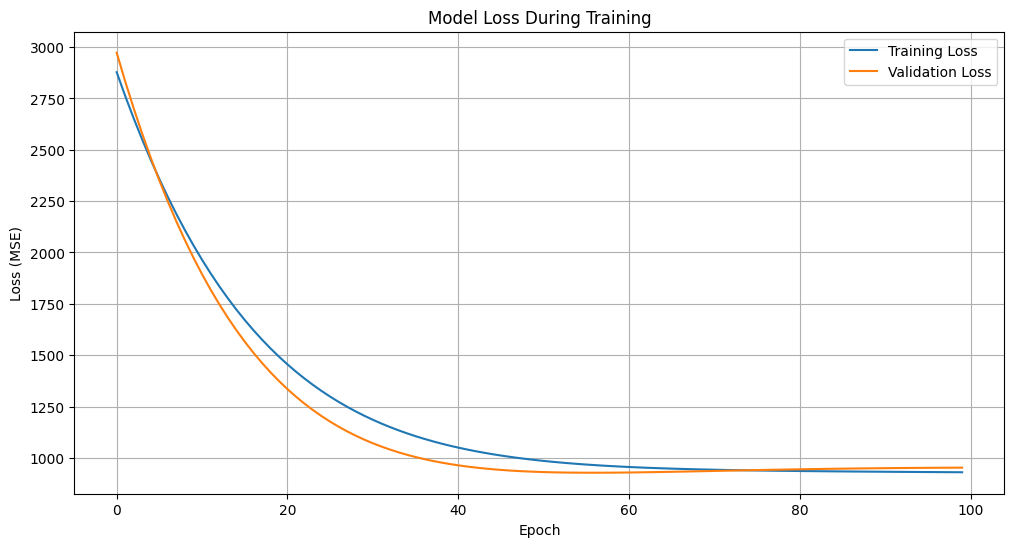

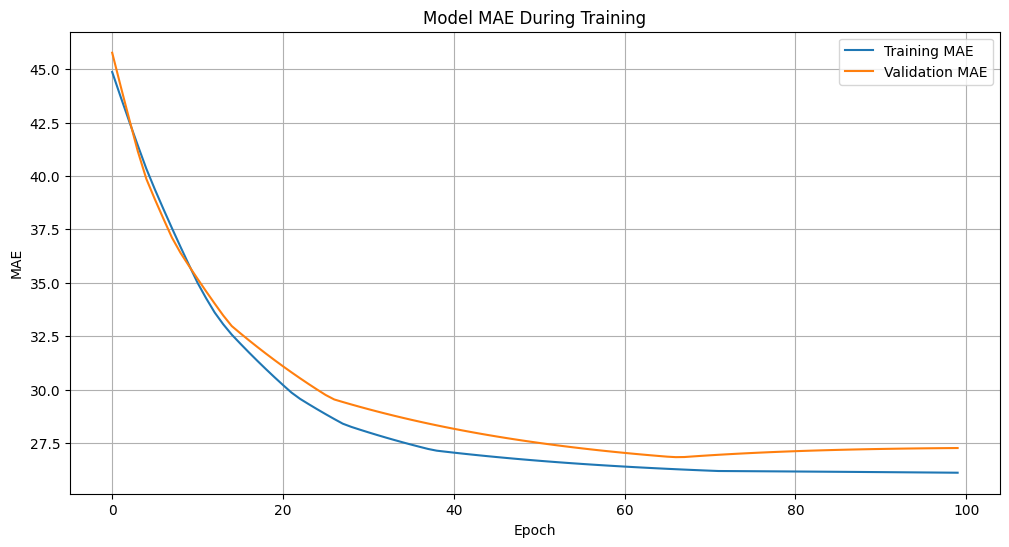

In [23]:
# Train the neural network model
epochs = 100 # Number of training epochs
history = model.fit(X_train_windowed, y_train_windowed,
                    epochs=epochs,
                    validation_data=(X_valid_windowed, y_valid_windowed),
                    verbose=0) # Set verbose to 1 or 2 for more detailed output during training

print(f"Neural network model trained for {epochs} epochs.")

# Optionally, plot the training history (loss and MAE over epochs)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

## Make predictions




In [24]:
# Make predictions on the validation set using the trained model
neural_network_predictions = model.predict(X_valid_windowed).flatten() # Flatten to get a 1D array

# Print the first few predictions
print("Neural Network Predictions on Validation Set (first 5):")
print(neural_network_predictions[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Neural Network Predictions on Validation Set (first 5):
[216.81294 202.17569 203.5379  187.41045 186.90904]


## Evaluate neural network model



In [25]:
# Calculate metrics for the neural network forecast
mae_nn = mae(y_valid_windowed, neural_network_predictions)
mse_nn = mse(y_valid_windowed, neural_network_predictions)
rmse_nn = rmse(y_valid_windowed, neural_network_predictions)
r2_nn = r2(y_valid_windowed, neural_network_predictions)

print(f"Neural Network Forecast Metrics:")
print(f"MAE: {mae_nn:.4f}")
print(f"MSE: {mse_nn:.4f}")
print(f"RMSE: {rmse_nn:.4f}")
print(f"R^2: {r2_nn:.4f}")

Neural Network Forecast Metrics:
MAE: 27.2665
MSE: 952.3340
RMSE: 30.8599
R^2: -7.5809


## Experiment with different window sizes




In [26]:
# Define a list of different window_size values to experiment with
window_sizes_to_experiment = [10, 20, 30, 40, 50]

# Dictionary to store metrics for each window size
nn_performance_by_window_size = {}

for current_window_size in window_sizes_to_experiment:
    print(f"\n--- Training and evaluating with window size: {current_window_size} ---")

    # 1. Create the windowed dataset
    X_windowed, y_windowed = window_dataset(df_sales_5years['Sales'].values, current_window_size)

    # 2. Split the windowed dataset
    current_split_index_windowed = split_time - current_window_size

    # Ensure the split index is valid (not negative)
    if current_split_index_windowed < 0:
        print(f"Warning: Window size {current_window_size} is too large for the dataset size and split point. Skipping.")
        continue

    X_train_windowed = X_windowed[:current_split_index_windowed]
    X_valid_windowed = X_windowed[current_split_index_windowed:]
    y_train_windowed = y_windowed[:current_split_index_windowed]
    y_valid_windowed = y_windowed[current_split_index_windowed:]

    print(f"  Split index for windowed data: {current_split_index_windowed}")
    print(f"  Shape of X_train_windowed: {X_train_windowed.shape}")
    print(f"  Shape of y_train_windowed: {y_train_windowed.shape}")
    print(f"  Shape of X_valid_windowed: {X_valid_windowed.shape}")
    print(f"  Shape of y_valid_windowed: {y_valid_windowed.shape}")

    # Check if valid set is empty
    if X_valid_windowed.shape[0] == 0:
        print(f"Warning: Validation set is empty for window size {current_window_size}. Skipping.")
        continue


    # 3. Build and compile a new sequential neural network model
    current_model = Sequential([
        Dense(1, input_shape=[current_window_size])
    ])

    current_model.compile(loss='mse',
                          optimizer=Adam(learning_rate=0.001),
                          metrics=['mae'])


    # 4. Train the new model
    current_epochs = 100
    current_model.fit(X_train_windowed, y_train_windowed,
                      epochs=current_epochs,
                      validation_data=(X_valid_windowed, y_valid_windowed),
                      verbose=0) # Set verbose=0 for less output during loop


    # 5. Make predictions on the validation set
    current_predictions = current_model.predict(X_valid_windowed).flatten()


    # 6. Calculate the evaluation metrics
    current_mae = mae(y_valid_windowed, current_predictions)
    current_mse = mse(y_valid_windowed, current_predictions)
    current_rmse = rmse(y_valid_windowed, current_predictions)
    current_r2 = r2(y_valid_windowed, current_predictions)

    # 7. Store the calculated metrics
    nn_performance_by_window_size[current_window_size] = {
        'MAE': current_mae,
        'MSE': current_mse,
        'RMSE': current_rmse,
        'R^2': current_r2
    }

    # 8. Print the metrics for the current window_size
    print(f"  Metrics for window size {current_window_size}:")
    print(f"    MAE: {current_mae:.4f}")
    print(f"    MSE: {current_mse:.4f}")
    print(f"    RMSE: {current_rmse:.4f}")
    print(f"    R^2: {current_r2:.4f}")

# 9. Analyze the stored metrics to find the best window size
print("\n--- Neural Network Performance by Window Size ---")
for window_size, metrics in nn_performance_by_window_size.items():
    print(f"Window Size {window_size}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R^2={metrics['R^2']:.4f}")

# Find the window size with the lowest MAE (or RMSE, or highest R^2)
best_window_size_mae = min(nn_performance_by_window_size, key=lambda ws: nn_performance_by_window_size[ws]['MAE'])
best_window_size_rmse = min(nn_performance_by_window_size, key=lambda ws: nn_performance_by_window_size[ws]['RMSE'])
best_window_size_r2 = max(nn_performance_by_window_size, key=lambda ws: nn_performance_by_window_size[ws]['R^2'])


print(f"\nBest Window Size based on MAE: {best_window_size_mae} (MAE: {nn_performance_by_window_size[best_window_size_mae]['MAE']:.4f})")
print(f"Best Window Size based on RMSE: {best_window_size_rmse} (RMSE: {nn_performance_by_window_size[best_window_size_rmse]['RMSE']:.4f})")
print(f"Best Window Size based on R^2: {best_window_size_r2} (R^2: {nn_performance_by_window_size[best_window_size_r2]['R^2']:.4f})")


--- Training and evaluating with window size: 10 ---
  Split index for windowed data: 38
  Shape of X_train_windowed: (38, 10)
  Shape of y_train_windowed: (38,)
  Shape of X_valid_windowed: (12, 10)
  Shape of y_valid_windowed: (12,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
  Metrics for window size 10:
    MAE: 41.6256
    MSE: 2467.4113
    RMSE: 49.6730
    R^2: -21.2324

--- Training and evaluating with window size: 20 ---
  Split index for windowed data: 28
  Shape of X_train_windowed: (28, 20)
  Shape of y_train_windowed: (28,)
  Shape of X_valid_windowed: (12, 20)
  Shape of y_valid_windowed: (12,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
  Metrics for window size 20:
    MAE: 37.6629
    MSE: 1685.5362
    RMSE: 41.0553
    R^2: -14.1874

--- Training and evaluating with window size: 30 ---
  Split index for windowed data: 18
  Shape of X_train_windowed: (18, 30)
  Shape of y_train_windowed: (18,)
  Shape of X_valid_windowed: (12, 30)
  Shape of y_valid_windowed: (12,)
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
  Metrics for window size 40:
    MAE: 16.1677
    MSE: 337.4106
    RMSE: 18.3687
    R^2: -2.0402

--- Training and evaluating with window size: 50 ---

--- Neural Network Performance by Window Size ---
Window Size 10: MAE=41.6256, RMSE=49.6730, R^2=-21.2324
Window Size 20: MAE=37.6629, RMSE=41.0553, R^2=-14.1874
Window Size 30: MAE=20.3011, RMSE=24.3785, R^2=-4.3550
Window Size 40: MAE=16.1677, RMSE=18.3687, R^2=-2.0402

Best Window Size based on MAE: 40 (MAE: 16.1677)
Best Window Size based on RMSE: 40 (RMSE: 18.3687)
Best Window Size based on R^2: 40 (R^2: -2.0402)


## Hyperparameter tuning



In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def build_nn_model(window_size, num_dense_layers, neurons_per_layer, activation, learning_rate):
    """
    Builds and compiles a sequential neural network model.

    Args:
        window_size (int): The size of the input window.
        num_dense_layers (int): The number of dense layers.
        neurons_per_layer (list): A list of the number of neurons for each dense layer.
        activation (str): The activation function for the dense layers.
        learning_rate (float): The learning rate for the Adam optimizer.

    Returns:
        tf.keras.models.Sequential: The compiled neural network model.
    """
    model = Sequential()
    # Add the first dense layer with the specified input shape and number of neurons
    model.add(Dense(neurons_per_layer[0], input_shape=[window_size], activation=activation))
    # Add additional dense layers if specified
    for i in range(1, num_dense_layers):
        model.add(Dense(neurons_per_layer[i], activation=activation))
    # Add the output layer
    model.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])

    return model

# Define hyperparameter combinations to experiment with
# Include variations in number of layers, neurons, activation functions, and learning rates
hyperparameter_combinations = [
    {'num_dense_layers': 1, 'neurons_per_layer': [10], 'activation': 'relu', 'learning_rate': 0.001},
    {'num_dense_layers': 1, 'neurons_per_layer': [20], 'activation': 'relu', 'learning_rate': 0.001},
    {'num_dense_layers': 1, 'neurons_per_layer': [10], 'activation': 'tanh', 'learning_rate': 0.001},
    {'num_dense_layers': 2, 'neurons_per_layer': [10, 10], 'activation': 'relu', 'learning_rate': 0.001},
    {'num_dense_layers': 2, 'neurons_per_layer': [20, 10], 'activation': 'relu', 'learning_rate': 0.001},
    {'num_dense_layers': 1, 'neurons_per_layer': [10], 'activation': 'relu', 'learning_rate': 0.01},
    {'num_dense_layers': 1, 'neurons_per_layer': [10], 'activation': 'relu', 'learning_rate': 0.0001},
]

print("Defined build_nn_model function and hyperparameter combinations.")

Defined build_nn_model function and hyperparameter combinations.


In [28]:
# Using the best window size found in the previous step (best_window_size_mae)
best_window_size = best_window_size_mae
print(f"Using the best window size found previously: {best_window_size}")

# Determine the split point for the windowed data using the best window size
X_windowed, y_windowed = window_dataset(df_sales_5years['Sales'].values, best_window_size)
split_index_windowed = split_time - best_window_size

if split_index_windowed < 0:
    print(f"Error: Best window size {best_window_size} is too large for the dataset size and split point.")
else:
    X_train_windowed = X_windowed[:split_index_windowed]
    X_valid_windowed = X_windowed[split_index_windowed:]
    y_train_windowed = y_windowed[:split_index_windowed]
    y_valid_windowed = y_windowed[split_index_windowed:]

    print(f"Split index for windowed data with best window size: {split_index_windowed}")
    print(f"Shape of X_train_windowed: {X_train_windowed.shape}")
    print(f"Shape of y_train_windowed: {y_train_windowed.shape}")
    print(f"Shape of X_valid_windowed: {X_valid_windowed.shape}")
    print(f"Shape of y_valid_windowed: {y_valid_windowed.shape}")

    # Dictionary to store metrics for each hyperparameter combination
    nn_performance_by_hyperparameters = {}
    epochs = 100 # Fixed number of epochs for hyperparameter tuning

    for i, params in enumerate(hyperparameter_combinations):
        print(f"\n--- Experimenting with Hyperparameter Combination {i+1}/{len(hyperparameter_combinations)} ---")
        print(f"Hyperparameters: {params}")

        # 1. Build and compile the neural network model with current hyperparameters
        current_model = build_nn_model(
            window_size=best_window_size,
            num_dense_layers=params['num_dense_layers'],
            neurons_per_layer=params['neurons_per_layer'],
            activation=params['activation'],
            learning_rate=params['learning_rate']
        )

        # 2. Train the model
        # Check if training data is empty
        if X_train_windowed.shape[0] == 0:
             print(f"Warning: Training set is empty for this window size. Skipping training.")
             current_mae, current_mse, current_rmse, current_r2 = np.nan, np.nan, np.nan, np.nan # Assign NaN if no training
        else:
            history = current_model.fit(X_train_windowed, y_train_windowed,
                                      epochs=epochs,
                                      validation_data=(X_valid_windowed, y_valid_windowed),
                                      verbose=0) # Set verbose=0 for less output during loop

            # 3. Make predictions on the validation set
            # Check if valid set is empty
            if X_valid_windowed.shape[0] == 0:
                print(f"Warning: Validation set is empty for this window size. Skipping prediction and evaluation.")
                current_predictions = np.array([]) # Empty array
                current_mae, current_mse, current_rmse, current_r2 = np.nan, np.nan, np.nan, np.nan # Assign NaN if no validation data
            else:
                current_predictions = current_model.predict(X_valid_windowed).flatten()

                # 4. Calculate the evaluation metrics
                current_mae = mae(y_valid_windowed, current_predictions)
                current_mse = mse(y_valid_windowed, current_predictions)
                current_rmse = rmse(y_valid_windowed, current_predictions)
                current_r2 = r2(y_valid_windowed, current_predictions)


        # 5. Store the calculated metrics with hyperparameters
        nn_performance_by_hyperparameters[str(params)] = { # Use string representation as key
            'hyperparameters': params,
            'MAE': current_mae,
            'MSE': current_mse,
            'RMSE': current_rmse,
            'R^2': current_r2
        }

        # 6. Print the metrics for the current combination
        print(f"  Metrics for this combination:")
        print(f"    MAE: {current_mae:.4f}")
        print(f"    MSE: {current_mse:.4f}")
        print(f"    RMSE: {current_rmse:.4f}")
        print(f"    R^2: {current_r2:.4f}")

    # 7. Analyze the stored metrics to find the best hyperparameters
    print("\n--- Neural Network Performance by Hyperparameter Combination ---")
    # Filter out combinations where metrics are NaN (due to empty data) before finding best
    valid_performances = {k: v for k, v in nn_performance_by_hyperparameters.items() if not np.isnan(v['MAE'])}

    if valid_performances:
        best_combination_mae_key = min(valid_performances, key=lambda k: valid_performances[k]['MAE'])
        best_combination_rmse_key = min(valid_performances, key=lambda k: valid_performances[k]['RMSE'])
        best_combination_r2_key = max(valid_performances, key=lambda k: valid_performances[k]['R^2'])

        best_combination_mae = valid_performances[best_combination_mae_key]
        best_combination_rmse = valid_performances[best_combination_rmse_key]
        best_combination_r2 = valid_performances[best_combination_r2_key]

        print(f"\nBest Hyperparameters based on MAE: {best_combination_mae['hyperparameters']}")
        print(f"  MAE: {best_combination_mae['MAE']:.4f}, RMSE: {best_combination_mae['RMSE']:.4f}, R^2: {best_combination_mae['R^2']:.4f}")

        print(f"\nBest Hyperparameters based on RMSE: {best_combination_rmse['hyperparameters']}")
        print(f"  MAE: {best_combination_rmse['MAE']:.4f}, RMSE: {best_combination_rmse['RMSE']:.4f}, R^2: {best_combination_rmse['R^2']:.4f}")

        print(f"\nBest Hyperparameters based on R^2: {best_combination_r2['hyperparameters']}")
        print(f"  MAE: {best_combination_r2['MAE']:.4f}, RMSE: {best_combination_r2['RMSE']:.4f}, R^2: {best_combination_r2['R^2']:.4f}")
    else:
        print("\nNo valid hyperparameter combinations were evaluated (likely due to empty datasets).")


Using the best window size found previously: 40
Split index for windowed data with best window size: 8
Shape of X_train_windowed: (8, 40)
Shape of y_train_windowed: (8,)
Shape of X_valid_windowed: (12, 40)
Shape of y_valid_windowed: (12,)

--- Experimenting with Hyperparameter Combination 1/7 ---
Hyperparameters: {'num_dense_layers': 1, 'neurons_per_layer': [10], 'activation': 'relu', 'learning_rate': 0.001}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
  Metrics for this combination:
    MAE: 33.2416
    MSE: 1318.9279
    RMSE: 36.3170
    R^2: -10.8841

--- Experimenting with Hyperparameter Combination 2/7 ---
Hyperparameters: {'num_dense_layers': 1, 'neurons_per_layer': [20], 'activation': 'relu', 'learning_rate': 0.001}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
  Metrics for this combination:
    MAE: 7.2309
    MSE: 74.1951
    RMSE: 8.6137
    R^2: 0.3315

--- Experimenting with Hyperparameter Combination 3/7 ---
Hyperparameters: {'num_dense_layers': 1, 'neurons_per_layer': [10], 'activation': 'tanh', 'learning_rate': 0.001}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
  Metrics for this combination:
    MAE: 206.0191
    MSE: 42554.8335
    RMSE: 206.2882
    R^2: -382.4365

--- Experimenting with Hyperparameter Combination 4/7 ---
Hyperparameters: {'num_dense_layers': 2, 'neurons_per_layer': [10, 10], 'activation': 'relu', 'learning_rate': 0.001}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
  Metrics for t

## Compare models




In [30]:
import json
import os

# Define the paths to the saved metrics files
naive_metrics_path = 'naive_forecast_metrics.json'
lr_metrics_path = 'linear_regression_metrics.json'

# Load metrics from the saved files
try:
    with open(naive_metrics_path, 'r') as f:
        naive_metrics_values = json.load(f)
    print(f"Loaded Naive Forecast metrics from {naive_metrics_path}")
except FileNotFoundError:
    print(f"Error: Naive Forecast metrics file not found at {naive_metrics_path}")
    naive_metrics_values = None # Set to None or handle as appropriate

try:
    with open(lr_metrics_path, 'r') as f:
        lr_metrics_values = json.load(f)
    print(f"Loaded Linear Regression metrics from {lr_metrics_path}")
except FileNotFoundError:
    print(f"Error: Linear Regression metrics file not found at {lr_metrics_path}")
    lr_metrics_values = None # Set to None or handle as appropriate

# Access metrics for the best neural network combination (using MAE as the primary metric for 'best')
# Ensure best_combination_mae is defined, if not, handle appropriately
if 'best_combination_mae' in locals():
    best_nn_metrics_values = best_combination_mae
    print("\n--- Comparison of Forecast Metrics (Naive vs. Linear Regression vs. Best Neural Network) ---")

    if naive_metrics_values:
        print("\nNaive Forecast Metrics:")
        print(f"MAE: {naive_metrics_values['MAE']:.4f}")
        print(f"MSE: {naive_metrics_values['MSE']:.4f}")
        print(f"RMSE: {naive_metrics_values['RMSE']:.4f}")
        print(f"R^2: {naive_metrics_values['R^2']:.4f}")
    else:
        print("\nNaive Forecast metrics not available.")

    if lr_metrics_values:
        print("\nLinear Regression Forecast Metrics:")
        print(f"MAE: {lr_metrics_values['MAE']:.4f}")
        print(f"MSE: {lr_metrics_values['MSE']:.4f}")
        print(f"RMSE: {lr_metrics_values['RMSE']:.4f}")
        print(f"R^2: {lr_metrics_values['R^2']:.4f}")
    else:
        print("\nLinear Regression metrics not available.")


    print("\nBest Neural Network Metrics:")
    print(f"Hyperparameters: {best_nn_metrics_values.get('hyperparameters', 'N/A')}") # Use .get for safety
    print(f"MAE: {best_nn_metrics_values.get('MAE', float('nan')):.4f}")
    print(f"MSE: {best_nn_metrics_values.get('MSE', float('nan')):.4f}")
    print(f"RMSE: {best_nn_metrics_values.get('RMSE', float('nan')):.4f}")
    print(f"R^2: {best_nn_metrics_values.get('R^2', float('nan')):.4f}")


    print("\n--- Comparison Summary ---")

    # Compare based on MAE (lower is better)
    mae_values = {}
    if naive_metrics_values: mae_values['Naive Forecast'] = naive_metrics_values['MAE']
    if lr_metrics_values: mae_values['Linear Regression'] = lr_metrics_values['MAE']
    if 'MAE' in best_nn_metrics_values and not np.isnan(best_nn_metrics_values['MAE']):
         mae_values['Best Neural Network'] = best_nn_metrics_values['MAE']

    if mae_values:
        best_mae_model = min(mae_values, key=mae_values.get)
        print(f"Model with the lowest MAE: {best_mae_model} (MAE: {mae_values[best_mae_model]:.4f})")
    else:
        print("MAE values not available for comparison.")


    # Compare based on RMSE (lower is better)
    rmse_values = {}
    if naive_metrics_values: rmse_values['Naive Forecast'] = naive_metrics_values['RMSE']
    if lr_metrics_values: rmse_values['Linear Regression'] = lr_metrics_values['RMSE']
    if 'RMSE' in best_nn_metrics_values and not np.isnan(best_nn_metrics_values['RMSE']):
         rmse_values['Best Neural Network'] = best_nn_metrics_values['RMSE']

    if rmse_values:
        best_rmse_model = min(rmse_values, key=rmse_values.get)
        print(f"Model with the lowest RMSE: {best_rmse_model} (RMSE: {rmse_values[best_rmse_model]:.4f})")
    else:
         print("RMSE values not available for comparison.")


    # Compare based on R^2 (higher is better)
    r2_values = {}
    if naive_metrics_values: r2_values['Naive Forecast'] = naive_metrics_values['R^2']
    if lr_metrics_values: r2_values['Linear Regression'] = lr_metrics_values['R^2']
    if 'R^2' in best_nn_metrics_values and not np.isnan(best_nn_metrics_values['R^2']):
         r2_values['Best Neural Network'] = best_nn_metrics_values['R^2']

    if r2_values:
        best_r2_model = max(r2_values, key=r2_values.get)
        print(f"Model with the highest R^2: {best_r2_model} (R^2: {r2_values[best_r2_model]:.4f})")
    else:
        print("R^2 values not available for comparison.")


    print("\nOverall Analysis:")
    # Provide a brief analysis based on available metrics
    if mae_values:
        best_mae_model = min(mae_values, key=mae_values.get)
        if best_mae_model == 'Best Neural Network':
            print("The best neural network model performed best based on MAE.")
        elif best_mae_model == 'Naive Forecast':
            print("The Naive Forecast model performed best based on MAE.")
        elif best_mae_model == 'Linear Regression':
            print("The Linear Regression model performed best based on MAE.")

    if rmse_values:
        best_rmse_model = min(rmse_values, key=rmse_values.get)
        if best_rmse_model == best_mae_model:
            print(f"The {best_mae_model} model also performed best based on RMSE.")
        else:
             print(f"The {best_rmse_model} model performed best based on RMSE.")

    if r2_values:
        best_r2_model = max(r2_values, key=r2_values.get)
        if best_r2_model == best_mae_model:
            print(f"The {best_mae_model} model also performed best based on R^2.")
        else:
            print(f"The {best_r2_model} model performed best based on R^2.")

    if len(mae_values) < 3 or len(rmse_values) < 3 or len(r2_values) < 3:
        print("\nNote: Some model metrics were not available for comparison.")

else:
    print("Error: 'best_combination_mae' variable is not defined. Please ensure the hyperparameter tuning step was executed successfully.")

Error: Naive Forecast metrics file not found at naive_forecast_metrics.json
Error: Linear Regression metrics file not found at linear_regression_metrics.json

--- Comparison of Forecast Metrics (Naive vs. Linear Regression vs. Best Neural Network) ---

Naive Forecast metrics not available.

Linear Regression metrics not available.

Best Neural Network Metrics:
Hyperparameters: {'num_dense_layers': 1, 'neurons_per_layer': [20], 'activation': 'relu', 'learning_rate': 0.001}
MAE: 7.2309
MSE: 74.1951
RMSE: 8.6137
R^2: 0.3315

--- Comparison Summary ---
Model with the lowest MAE: Best Neural Network (MAE: 7.2309)
Model with the lowest RMSE: Best Neural Network (RMSE: 8.6137)
Model with the highest R^2: Best Neural Network (R^2: 0.3315)

Overall Analysis:
The best neural network model performed best based on MAE.
The Best Neural Network model also performed best based on RMSE.
The Best Neural Network model also performed best based on R^2.

Note: Some model metrics were not available for com

## Visualize neural network results




Retraining the best NN model with window size: 40
Training the best NN model on the full windowed dataset for 100 epochs.
Best NN model trained successfully on the full dataset.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


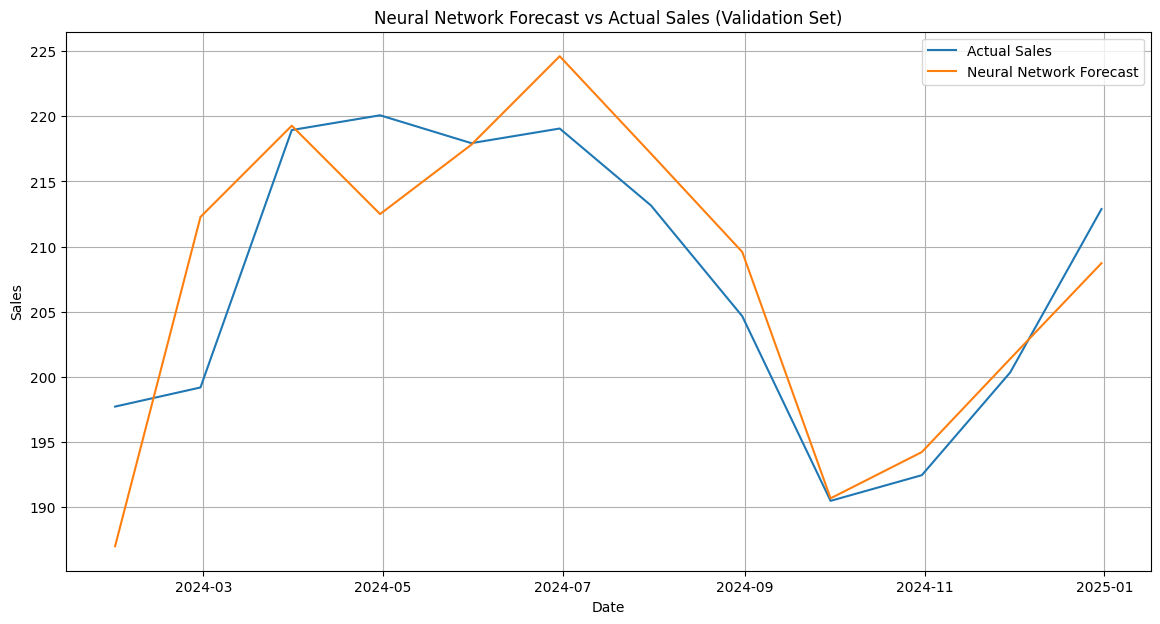

In [34]:
# Retrain the best performing NN model on the entire windowed dataset with the best hyperparameters
# Using the best window size found in the previous step (best_window_size_mae)
best_window_size = best_window_size_mae
print(f"Retraining the best NN model with window size: {best_window_size}")

# Using the best hyperparameters found in the previous step
best_hyperparameters = best_combination_mae['hyperparameters'] # Assuming best_combination_mae holds the best params

# 1. Create the windowed dataset for the entire series
X_windowed_full, y_windowed_full = window_dataset(df_sales_5years['Sales'].values, best_window_size)

# 2. Build and compile the best neural network model
best_nn_model = build_nn_model(
    window_size=best_window_size,
    num_dense_layers=best_hyperparameters['num_dense_layers'],
    neurons_per_layer=best_hyperparameters['neurons_per_layer'],
    activation=best_hyperparameters['activation'],
    learning_rate=best_hyperparameters['learning_rate']
)

# 3. Train the model on the entire windowed dataset
epochs = 100 # Use the same number of epochs as in tuning
print(f"Training the best NN model on the full windowed dataset for {epochs} epochs.")
best_nn_model.fit(X_windowed_full, y_windowed_full, epochs=epochs, verbose=0)

print("Best NN model trained successfully on the full dataset.")

# 4. Prepare data for prediction on the validation set using the trained model
# Make predictions on the validation set using the retrained model
best_nn_predictions = best_nn_model.predict(X_valid_windowed).flatten() # Use X_valid_windowed from the split based on best_window_size

# 5. Plot the actual sales and the predictions from the best neural network model on the validation set.
plt.figure(figsize=(14, 7))
plt.plot(time_valid, y_valid, label='Actual Sales') # Plot actual validation sales against time_valid
plt.plot(time_valid, best_nn_predictions, label='Neural Network Forecast') # Plot NN predictions against time_valid
plt.title("Neural Network Forecast vs Actual Sales (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Calculate metrics for the best neural network forecast on the validation set
mae_best_nn = mae(y_valid, best_nn_predictions)
mse_best_nn = mse(y_valid, best_nn_predictions)
rmse_best_nn = rmse(y_valid, best_nn_predictions)
r2_best_nn = r2(y_valid, best_nn_predictions)

print(f"Best Neural Network Forecast Metrics (on Validation Set):")
print(f"MAE: {mae_best_nn:.4f}")
print(f"MSE: {mse_best_nn:.4f}")
print(f"RMSE: {rmse_best_nn:.4f}")
print(f"R^2: {r2_best_nn:.4f}")

Best Neural Network Forecast Metrics (on Validation Set):
MAE: 4.4553
MSE: 36.3453
RMSE: 6.0287
R^2: 0.6725


Best Neural Network Residuals Statistics:


,yt+1
count,12.000000
mean,-0.693155
std,6.255018
min,-13.084549
25%,-4.216451
50%,-0.690336
75%,1.127860
max,10.716703


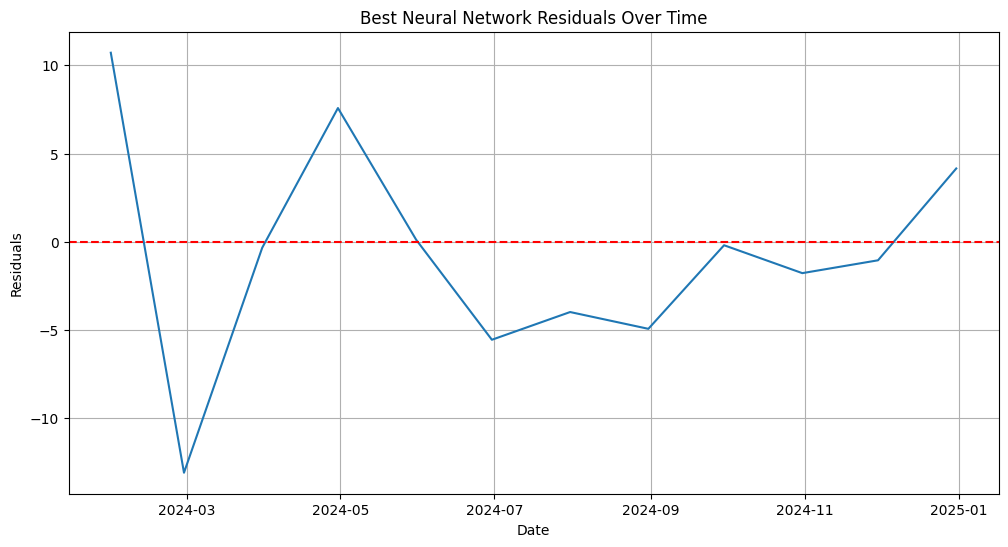

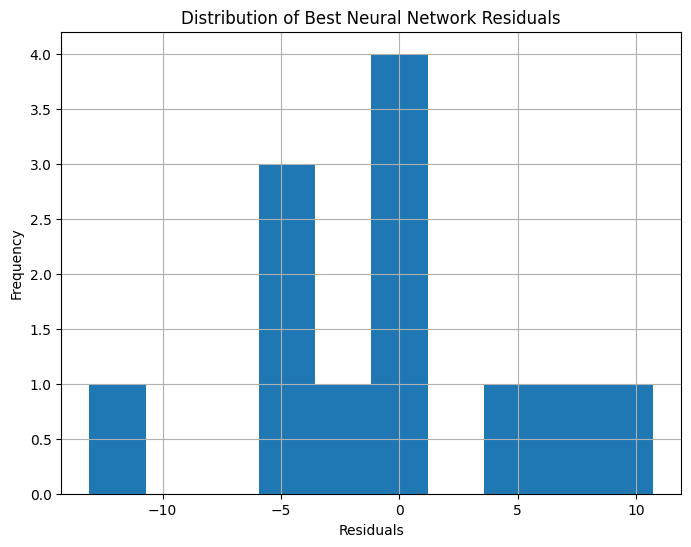

In [36]:
# Calculate residuals for the best neural network model
best_nn_residuals = y_valid - best_nn_predictions

# Print basic statistics of the residuals
print("Best Neural Network Residuals Statistics:")
display(best_nn_residuals.describe())

# Create a line plot of the residuals over time
plt.figure(figsize=(12, 6))
plt.plot(time_valid, best_nn_residuals)
plt.title("Best Neural Network Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at y=0 for reference
plt.grid(True)
plt.show()

# Create a histogram of the residuals
plt.figure(figsize=(8, 6))
plt.hist(best_nn_residuals, bins=10) # Adjust bins as needed
plt.title("Distribution of Best Neural Network Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Save neural network results



In [ ]:
import json
import os
import shutil
import tensorflow as tf

# Define the destination directory on Google Drive
nn_forecast_dir = '/content/drive/MyDrive/Time series/Neural Network'

# Create the destination directory if it doesn't exist
os.makedirs(nn_forecast_dir, exist_ok=True)
print(f"Created directory: {nn_forecast_dir}")

# 1. Save the best neural network model
model_filename = 'best_neural_network_model.keras'
best_nn_model.save(model_filename)
print(f"Saved best neural network model to {model_filename}")

# 2. Create a DataFrame to save predictions, actual values, and residuals
best_nn_results = pd.DataFrame({
    'Actual': y_valid,
    'Neural_Network_Forecast': best_nn_predictions,
    'Residuals': best_nn_residuals
})

# Save the results DataFrame to a CSV file
results_filename_nn = 'best_neural_network_results.csv'
best_nn_results.to_csv(results_filename_nn)
print(f"Saved best neural network results to {results_filename_nn}")

# 3. Create a dictionary for evaluation metrics
best_nn_metrics = {
    'MAE': mae_best_nn,
    'MSE': mse_best_nn,
    'RMSE': rmse_best_nn,
    'R^2': r2_best_nn,
    'Hyperparameters': best_hyperparameters,
    'Window_Size': best_window_size
}

# Save the evaluation metrics to a JSON file
metrics_filename_nn = 'best_neural_network_metrics.json'
with open(metrics_filename_nn, 'w') as f:
    json.dump(best_nn_metrics, f, indent=4)
print(f"Saved best neural network metrics to {metrics_filename_nn}")

# 4. Save the plots as image files

# Save the NN Forecast vs Actual plot
nn_forecast_plot_filename = 'neural_network_vs_actual_plot.png'
plt.figure(figsize=(14, 7))
plt.plot(time_valid, y_valid, label='Actual Sales')
plt.plot(time_valid, best_nn_predictions, label='Neural Network Forecast')
plt.title("Neural Network Forecast vs Actual Sales (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.savefig(nn_forecast_plot_filename)
plt.close() # Close the plot
print(f"Saved Neural Network Forecast vs Actual plot to {nn_forecast_plot_filename}")

# Save the NN Residuals Over Time plot
nn_residuals_time_plot_filename = 'neural_network_residuals_time_plot.png'
plt.figure(figsize=(12, 6))
plt.plot(time_valid, best_nn_residuals)
plt.title("Best Neural Network Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.savefig(nn_residuals_time_plot_filename)
plt.close() # Close the plot
print(f"Saved Neural Network Residuals Over Time plot to {nn_residuals_time_plot_filename}")

# Save the Distribution of NN Residuals plot
nn_residuals_hist_plot_filename = 'neural_network_residuals_histogram_plot.png'
plt.figure(figsize=(8, 6))
plt.hist(best_nn_residuals, bins=10)
plt.title("Distribution of Best Neural Network Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig(nn_residuals_hist_plot_filename)
plt.close() # Close the plot
print(f"Saved Neural Network Residuals Histogram plot to {nn_residuals_hist_plot_filename}")

# 5. Move the saved files to the Google Drive directory
shutil.move(model_filename, nn_forecast_dir)
shutil.move(results_filename_nn, nn_forecast_dir)
shutil.move(metrics_filename_nn, nn_forecast_dir)
shutil.move(nn_forecast_plot_filename, nn_forecast_dir)
shutil.move(nn_residuals_time_plot_filename, nn_forecast_dir)
shutil.move(nn_residuals_hist_plot_filename, nn_forecast_dir)


print(f"Moved {model_filename} to {nn_forecast_dir}")
print(f"Moved {results_filename_nn} to {nn_forecast_dir}")
print(f"Moved {metrics_filename_nn} to {nn_forecast_dir}")
print(f"Moved {nn_forecast_plot_filename} to {nn_forecast_dir}")
print(f"Moved {nn_residuals_time_plot_filename} to {nn_forecast_dir}")
print(f"Moved {nn_residuals_hist_plot_filename} to {nn_forecast_dir}")

# 6. Verify the files are in the Google Drive directory
contents_nn = os.listdir(nn_forecast_dir)
print(f"Contents of '{nn_forecast_dir}':")
print(contents_nn)

## Analyze residuals


Best Neural Network Residuals Statistics:


,yt+1
count,12.000000
mean,-0.693155
std,6.255018
min,-13.084549
25%,-4.216451
50%,-0.690336
75%,1.127860
max,10.716703


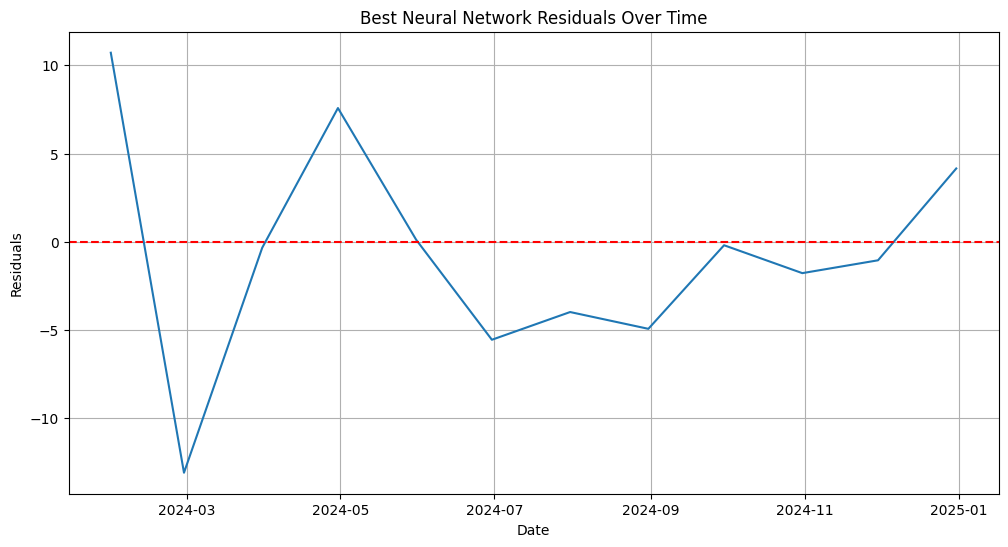

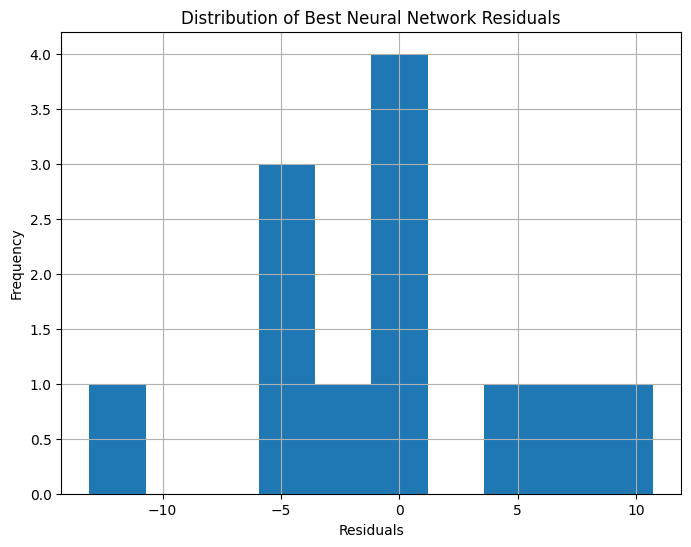

In [37]:
# Calculate residuals for the best neural network model
best_nn_residuals = y_valid - best_nn_predictions

# Print basic statistics of the residuals
print("Best Neural Network Residuals Statistics:")
display(best_nn_residuals.describe())

# Create a line plot of the residuals over time
plt.figure(figsize=(12, 6))
plt.plot(time_valid, best_nn_residuals)
plt.title("Best Neural Network Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at y=0 for reference
plt.grid(True)
plt.show()

# Create a histogram of the residuals
plt.figure(figsize=(8, 6))
plt.hist(best_nn_residuals, bins=10) # Adjust bins as needed
plt.title("Distribution of Best Neural Network Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Windowed Dataset

In [68]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Define a single window size for this section's models (MLP, RNN, LSTM, CNN)
# Choosing a window size that allows for a non-empty validation set (less than 12)
window_size = 10
batch_size = 32
shuffle_buffer_size = 1000

# Create training dataset using the selected window size
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Create validation dataset using the SAME window size
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# Optional: Print dataset shapes to verify
print("Training dataset element spec:", train_dataset.element_spec)
print("Validation dataset element spec:", valid_dataset.element_spec)

Training dataset element spec: (TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))
Validation dataset element spec: (TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))


In [69]:
def train_and_evaluate(model, train_dataset, val_dataset, model_name, epochs=20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  # Train the model
  history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[early_stopping], verbose=0)

  # --- Manual Prediction and Evaluation on Validation Set ---
  actual_valid_values = []
  predictions = []

  # Iterate through the validation dataset to collect actual values and make predictions
  for X_batch, y_batch in val_dataset:
      actual_valid_values.extend(y_batch.numpy())
      predictions.extend(model.predict(X_batch).flatten())

  actual_valid_values = np.array(actual_valid_values)
  predictions = np.array(predictions)

  if actual_valid_values.shape[0] > 0:
      # Calculate metrics manually
      current_mae = mae(actual_valid_values, predictions)
      current_mse = mse(actual_valid_values, predictions)
      current_rmse = rmse(actual_valid_values, predictions)
      current_r2 = r2(actual_valid_values, predictions)

      print(f"  Metrics for {model_name} on Validation Set:")
      print(f"    MAE: {current_mae:.4f}")
      print(f"    MSE: {current_mse:.4f}")
      print(f"    RMSE: {current_rmse:.4f}")
      print(f"    R^2: {current_r2:.4f}")

      loss = current_mse # Use MSE as the representative loss for comparison

  else:
      print(f"Warning: Validation dataset is empty for {model_name}. Skipping evaluation.")
      loss = float('nan') # Assign NaN if no validation data


  model.save(f"{model_name}_model.h5")
  print(f"{model_name} model saved.")
  return history, loss

In [70]:
#define metrics(MAE,MSE,RMSE,MAPE,R^2)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mape(y_true, y_pred):
    # Avoid division by zero or very small numbers in y_true
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan


def r2(y_true, y_pred):
    # Handle cases where y_true has zero variance
    if np.sum((y_true - np.mean(y_true)) ** 2) == 0:
        return np.nan # R^2 is undefined if y_true has no variance
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))


# modele MLP
def build_mlp_model(window_size):
  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=(window_size,)), # Use Input layer
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1)
  ])
  model.compile(loss="mse", optimizer='adam')
  return model


#modele RNN simple
def build_rnn_model(window_size):
  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=(window_size,)), # Use Input layer
      tf.keras.layers.Reshape((window_size, 1)), # Reshape for RNN input
      tf.keras.layers.SimpleRNN(64, return_sequences=True),
      tf.keras.layers.SimpleRNN(64),
      tf.keras.layers.Dense(1)
  ])
  model.compile(loss="mse", optimizer='adam')
  return model

#LSTM Bidirectionnel
def build_lstm_model(window_size):
  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=(window_size,)), # Use Input layer
      tf.keras.layers.Reshape((window_size, 1)), # Reshape for LSTM input
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu')),
      tf.keras.layers.Dense(1)
  ])
  model.compile(loss="mse", optimizer='adam')
  return model


#Modele CNN 1D
def build_cnn_model(window_size):
  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=(window_size,)), # Use Input layer
      tf.keras.layers.Reshape((window_size, 1)), # Reshape for CNN input
      tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
  model.compile(loss="mse", optimizer='adam')
  return model

## Train and Evaluate MLP Model

In [71]:
# Build the MLP model
mlp_model = build_mlp_model(window_size)

# Train and evaluate the MLP model
print("Training and evaluating MLP model...")
history_mlp, loss_mlp = train_and_evaluate(mlp_model, train_dataset, valid_dataset, "mlp")

print(f"MLP Model Validation Loss: {loss_mlp:.4f}")

Training and evaluating MLP model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  Metrics for mlp on Validation Set:
    MAE: 6.0231
    MSE: 66.2516
    RMSE: 8.1395
    R^2: -0.6847
mlp model saved.
MLP Model Validation Loss: 66.2516


## Train and Evaluate Simple RNN Model

In [72]:
# Build the Simple RNN model
rnn_model = build_rnn_model(window_size)

# Train and evaluate the Simple RNN model
print("\nTraining and evaluating Simple RNN model...")
history_rnn, loss_rnn = train_and_evaluate(rnn_model, train_dataset, valid_dataset, "rnn")

print(f"Simple RNN Model Validation Loss: {loss_rnn:.4f}")


Training and evaluating Simple RNN model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


  Metrics for rnn on Validation Set:
    MAE: 194.4048
    MSE: 37832.5602
    RMSE: 194.5059
    R^2: -961.0506
rnn model saved.
Simple RNN Model Validation Loss: 37832.5602


## Train and Evaluate Bidirectional LSTM Model

In [73]:
# Build the Bidirectional LSTM model
lstm_model = build_lstm_model(window_size)

# Train and evaluate the Bidirectional LSTM model
print("\nTraining and evaluating Bidirectional LSTM model...")
history_lstm, loss_lstm = train_and_evaluate(lstm_model, train_dataset, valid_dataset, "lstm")

print(f"Bidirectional LSTM Model Validation Loss: {loss_lstm:.4f}")


Training and evaluating Bidirectional LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


  Metrics for lstm on Validation Set:
    MAE: 6.0305
    MSE: 42.1429
    RMSE: 6.4918
    R^2: -0.0717
lstm model saved.
Bidirectional LSTM Model Validation Loss: 42.1429


## Train and Evaluate 1D CNN Model

In [74]:
# Build the 1D CNN model
cnn_model = build_cnn_model(window_size)

# Train and evaluate the 1D CNN model
print("\nTraining and evaluating 1D CNN model...")
history_cnn, loss_cnn = train_and_evaluate(cnn_model, train_dataset, valid_dataset, "cnn")

print(f"1D CNN Model Validation Loss: {loss_cnn:.4f}")


Training and evaluating 1D CNN model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  Metrics for cnn on Validation Set:
    MAE: 7.6148
    MSE: 110.8585
    RMSE: 10.5289
    R^2: -1.8190
cnn model saved.
1D CNN Model Validation Loss: 110.8585


## Compare Models

In [75]:
# Compare the validation losses of the models
print("\n--- Model Comparison (Validation Loss) ---")
print(f"MLP Model: {loss_mlp:.4f}")
print(f"Simple RNN Model: {loss_rnn:.4f}")
print(f"Bidirectional LSTM Model: {loss_lstm:.4f}")
print(f"1D CNN Model: {loss_cnn:.4f}")

# Determine the best model based on the lowest validation loss
model_losses = {
    'MLP': loss_mlp,
    'Simple RNN': loss_rnn,
    'LSTM': loss_lstm,
    'CNN': loss_cnn
}

best_model_name = min(model_losses, key=model_losses.get)
best_loss = model_losses[best_model_name]

print(f"\nBest performing model based on validation loss: {best_model_name} (Loss: {best_loss:.4f})")

# Assign the best model object based on the name
if best_model_name == 'MLP':
    best_model = mlp_model
elif best_model_name == 'Simple RNN':
    best_model = rnn_model
elif best_model_name == 'LSTM':
    best_model = lstm_model
elif best_model_name == 'CNN':
    best_model = cnn_model


--- Model Comparison (Validation Loss) ---
MLP Model: 66.2516
Simple RNN Model: 37832.5602
Bidirectional LSTM Model: 42.1429
1D CNN Model: 110.8585

Best performing model based on validation loss: LSTM (Loss: 42.1429)


## Visualize and Analyze Best Model Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


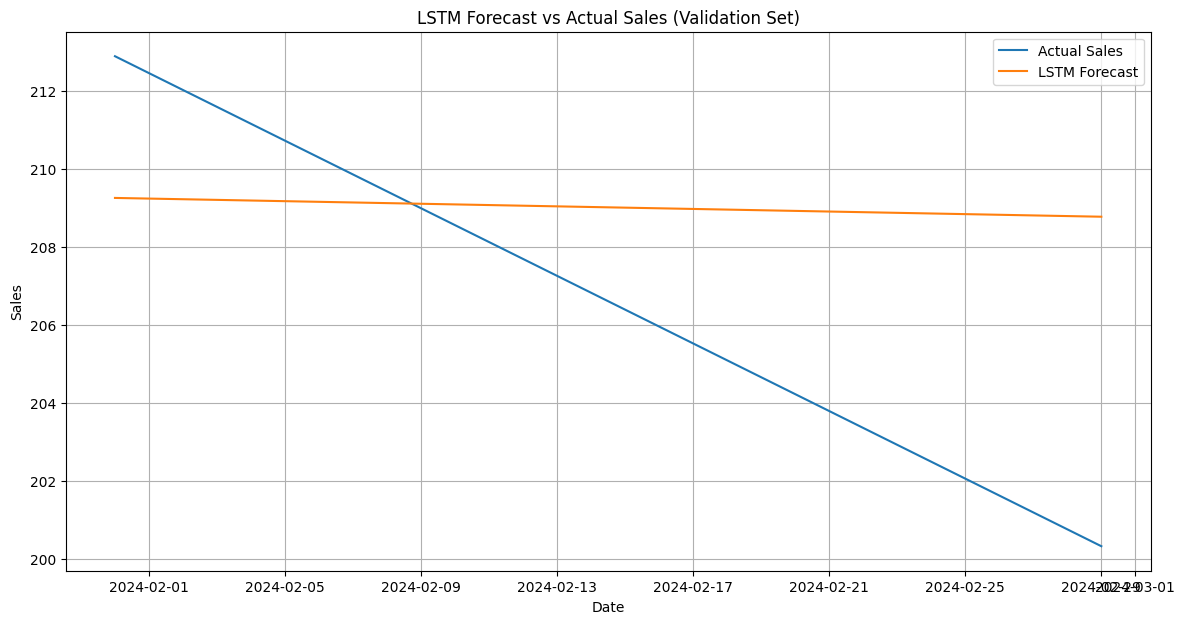


LSTM Residuals Statistics:


,0
count,2.000000
mean,-2.403334
std,8.528408
min,-8.433829
25%,-5.418581
50%,-2.403334
75%,0.611914
max,3.627161


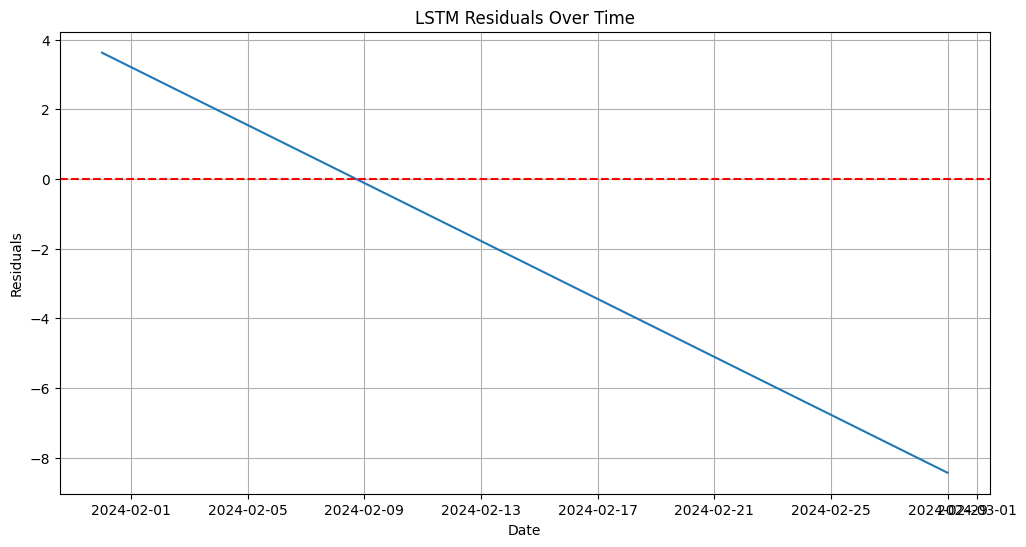

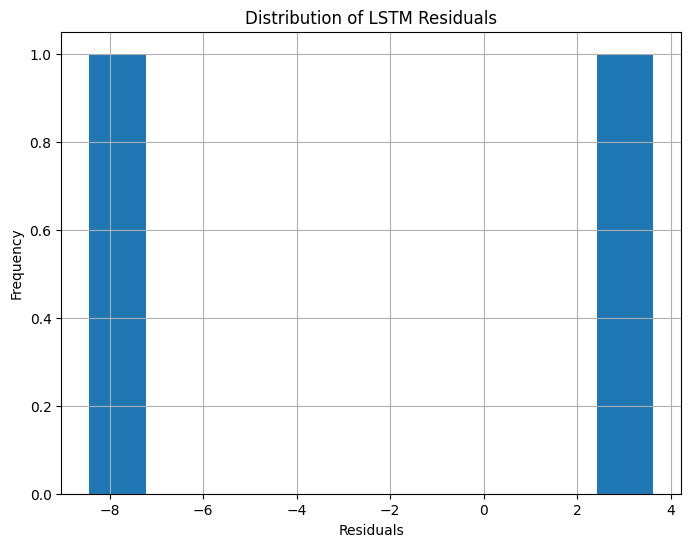

In [76]:
# Make predictions on the validation set using the best model
best_model_predictions = best_model.predict(valid_dataset).flatten()

# Get actual values from the validation dataset for plotting and evaluation
# This requires iterating through the validation dataset once
actual_valid_values = []
for X_batch, y_batch in valid_dataset:
    actual_valid_values.extend(y_batch.numpy())
actual_valid_values = np.array(actual_valid_values)

# Ensure predictions and actual values have the same length
min_len = min(len(best_model_predictions), len(actual_valid_values))
best_model_predictions = best_model_predictions[:min_len]
actual_valid_values = actual_valid_values[:min_len]

# Plot Actual vs. Best Model Forecast on the validation set
plt.figure(figsize=(14, 7))
# Use time_valid to plot against, ensuring it aligns with the length of actual_valid_values
plt.plot(time_valid[:len(actual_valid_values)], actual_valid_values, label='Actual Sales')
plt.plot(time_valid[:len(best_model_predictions)], best_model_predictions, label=f'{best_model_name} Forecast')
plt.title(f"{best_model_name} Forecast vs Actual Sales (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

# Calculate and plot residuals for the best model
best_model_residuals = actual_valid_values - best_model_predictions

print(f"\n{best_model_name} Residuals Statistics:")
display(pd.Series(best_model_residuals).describe()) # Use pandas Series for describe

plt.figure(figsize=(12, 6))
plt.plot(time_valid[:len(best_model_residuals)], best_model_residuals)
plt.title(f"{best_model_name} Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(best_model_residuals, bins=10)
plt.title(f"Distribution of {best_model_name} Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Visualize Comparison of All Models

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


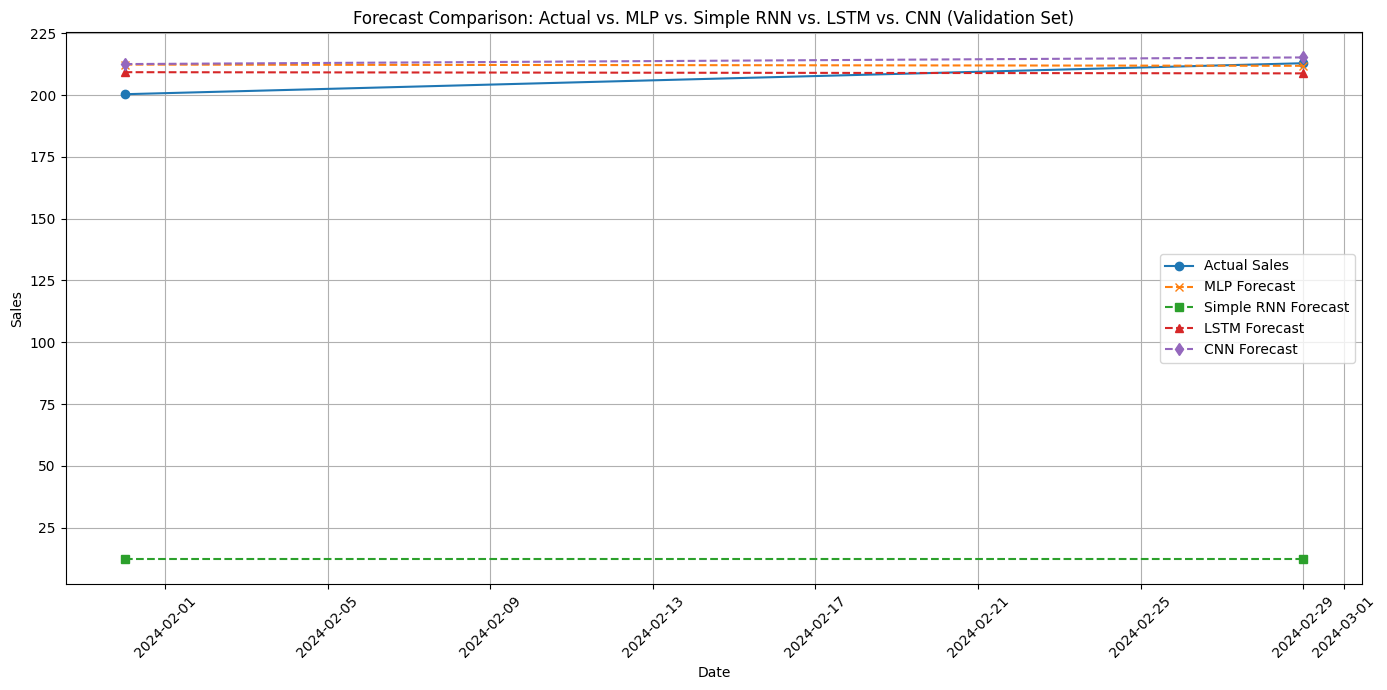

In [77]:
# Make predictions on the validation set for each model
mlp_predictions = mlp_model.predict(valid_dataset).flatten()
rnn_predictions = rnn_model.predict(valid_dataset).flatten()
lstm_predictions = lstm_model.predict(valid_dataset).flatten()
cnn_predictions = cnn_model.predict(valid_dataset).flatten()

# Get actual values from the validation dataset (already done in train_and_evaluate, but doing again for clarity)
actual_valid_values = []
for X_batch, y_batch in valid_dataset:
    actual_valid_values.extend(y_batch.numpy())
actual_valid_values = np.array(actual_valid_values)

# Ensure all prediction arrays have the same length as actual_valid_values
min_len = len(actual_valid_values)
mlp_predictions = mlp_predictions[:min_len]
rnn_predictions = rnn_predictions[:min_len]
lstm_predictions = lstm_predictions[:min_len]
cnn_predictions = cnn_predictions[:min_len]


# Plot Actual vs. Predictions for all models on the validation set
plt.figure(figsize=(14, 7))

plt.plot(time_valid[:min_len], actual_valid_values, label='Actual Sales', marker='o')
plt.plot(time_valid[:min_len], mlp_predictions, label='MLP Forecast', linestyle='--', marker='x')
plt.plot(time_valid[:min_len], rnn_predictions, label='Simple RNN Forecast', linestyle='--', marker='s')
plt.plot(time_valid[:min_len], lstm_predictions, label='LSTM Forecast', linestyle='--', marker='^')
plt.plot(time_valid[:min_len], cnn_predictions, label='CNN Forecast', linestyle='--', marker='d')


plt.title("Forecast Comparison: Actual vs. MLP vs. Simple RNN vs. LSTM vs. CNN (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Save Best Model Results

In [78]:
import json
import os
import shutil

# Define the destination directory on Google Drive
windowed_dataset_dir = '/content/drive/MyDrive/Time series/Windowed_dataset'

# Create the destination directory if it doesn't exist
os.makedirs(windowed_dataset_dir, exist_ok=True)
print(f"Created directory: {windowed_dataset_dir}")

# 1. Save the best neural network model
model_filename = f'{best_model_name}_best_model.keras'
best_model.save(model_filename)
print(f"Saved best model to {model_filename}")

# 2. Create a DataFrame to save predictions, actual values, and residuals
best_model_results = pd.DataFrame({
    'Actual': actual_valid_values,
    f'{best_model_name}_Forecast': best_model_predictions,
    'Residuals': best_model_residuals
}, index=time_valid[:len(actual_valid_values)]) # Use the appropriate part of time_valid

# Save the results DataFrame to a CSV file
results_filename = f'{best_model_name}_results.csv'
best_model_results.to_csv(results_filename)
print(f"Saved best model results to {results_filename}")

# 3. Calculate and save evaluation metrics for the best model
# Need to re-calculate metrics using the actual_valid_values and best_model_predictions
mae_best = mae(actual_valid_values, best_model_predictions)
mse_best = mse(actual_valid_values, best_model_predictions)
rmse_best = rmse(actual_valid_values, best_model_predictions)
r2_best = r2(actual_valid_values, best_model_predictions)


best_model_metrics = {
    'Model': best_model_name,
    'Window_Size': window_size, # Assuming window_size is the one used for train/valid_dataset
    'MAE': mae_best,
    'MSE': mse_best,
    'RMSE': rmse_best,
    'R^2': r2_best
}

# Save the evaluation metrics to a JSON file
metrics_filename = f'{best_model_name}_metrics.json'
with open(metrics_filename, 'w') as f:
    json.dump(best_model_metrics, f, indent=4)
print(f"Saved best model metrics to {metrics_filename}")

# 4. Save the plots as image files

# Save the Forecast vs Actual plot
forecast_plot_filename = f'{best_model_name}_forecast_vs_actual_plot.png'
plt.figure(figsize=(14, 7))
plt.plot(time_valid[:len(actual_valid_values)], actual_valid_values, label='Actual Sales')
plt.plot(time_valid[:len(best_model_predictions)], best_model_predictions, label=f'{best_model_name} Forecast')
plt.title(f"{best_model_name} Forecast vs Actual Sales (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.savefig(forecast_plot_filename)
plt.close()
print(f"Saved {best_model_name} Forecast vs Actual plot to {forecast_plot_filename}")

# Save the Residuals Over Time plot
residuals_time_plot_filename = f'{best_model_name}_residuals_time_plot.png'
plt.figure(figsize=(12, 6))
plt.plot(time_valid[:len(best_model_residuals)], best_model_residuals)
plt.title(f"{best_model_name} Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.savefig(residuals_time_plot_filename)
plt.close()
print(f"Saved {best_model_name} Residuals Over Time plot to {residuals_time_plot_filename}")

# Save the Distribution of Residuals plot
residuals_hist_plot_filename = f'{best_model_name}_residuals_histogram_plot.png'
plt.figure(figsize=(8, 6))
plt.hist(best_model_residuals, bins=10)
plt.title(f"Distribution of {best_model_name} Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig(residuals_hist_plot_filename)
plt.close()
print(f"Saved {best_model_name} Residuals Histogram plot to {residuals_hist_plot_filename}")


# 5. Move the saved files to the Google Drive directory
shutil.move(model_filename, windowed_dataset_dir)
shutil.move(results_filename, windowed_dataset_dir)
shutil.move(metrics_filename, windowed_dataset_dir)
shutil.move(forecast_plot_filename, windowed_dataset_dir)
shutil.move(residuals_time_plot_filename, windowed_dataset_dir)
shutil.move(residuals_hist_plot_filename, windowed_dataset_dir)


print(f"Moved {model_filename} to {windowed_dataset_dir}")
print(f"Moved {results_filename} to {windowed_dataset_dir}")
print(f"Moved {metrics_filename} to {windowed_dataset_dir}")
print(f"Moved {forecast_plot_filename} to {windowed_dataset_dir}")
print(f"Moved {residuals_time_plot_filename} to {windowed_dataset_dir}")
print(f"Moved {residuals_hist_plot_filename} to {windowed_dataset_dir}")

# 6. Verify the files are in the Google Drive directory
contents_windowed = os.listdir(windowed_dataset_dir)
print(f"Contents of '{windowed_dataset_dir}':")
print(contents_windowed)

Created directory: /content/drive/MyDrive/Time series/Windowed_dataset
Saved best model to LSTM_best_model.keras
Saved best model results to LSTM_results.csv
Saved best model metrics to LSTM_metrics.json
Saved LSTM Forecast vs Actual plot to LSTM_forecast_vs_actual_plot.png
Saved LSTM Residuals Over Time plot to LSTM_residuals_time_plot.png
Saved LSTM Residuals Histogram plot to LSTM_residuals_histogram_plot.png
Moved LSTM_best_model.keras to /content/drive/MyDrive/Time series/Windowed_dataset
Moved LSTM_results.csv to /content/drive/MyDrive/Time series/Windowed_dataset
Moved LSTM_metrics.json to /content/drive/MyDrive/Time series/Windowed_dataset
Moved LSTM_forecast_vs_actual_plot.png to /content/drive/MyDrive/Time series/Windowed_dataset
Moved LSTM_residuals_time_plot.png to /content/drive/MyDrive/Time series/Windowed_dataset
Moved LSTM_residuals_histogram_plot.png to /content/drive/MyDrive/Time series/Windowed_dataset
Contents of '/content/drive/MyDrive/Time series/Windowed_dataset'